# Milestone Project 2: SkimLit

Sequence Problem:
Many to One Classification

* Download PubMed 200k RCT dataset
* Preprocess the text data
* Set up multiple modeling experiments
* Build a multimodal model to take in different sources of data
  * Replicate the model powering https://arxiv.org/abs/1710.06071
* Find the most wrong prediction examples

## Skim Medical Literature 

A Dataset for sequential Sentence Classification in Medical Abastracts:

[Source](https://arxiv.org/abs/1710.06071)

[Model Architecture](https://arxiv.org/abs/1612.05251)

Artificial Neural Network consisting of 3 main components:
* Token embedding layer (bi-LSTM)
* Sentence label prediction layer (bi-LSTM)
* Label sequence optimization layer (CRF)


In [1]:
#Confirm access to GPU
!nvidia-smi -L

GPU 0: NVIDIA GeForce RTX 3070 Laptop GPU (UUID: GPU-a72a565b-b891-b764-c0f7-6096f5184f0e)


In [2]:
# Get dataset
!git clone https://github.com/Franck-Dernoncourt/pubmed-rct.git ../Downloads/09_skimlit_milestone_project

fatal: destination path '../Downloads/09_skimlit_milestone_project' already exists and is not an empty directory.


In [3]:
# Check downloaded folders
!ls ../Downloads/09_skimlit_milestone_project

# Check files in the one of the folders
!ls ../Downloads/09_skimlit_milestone_project/PubMed_20k_RCT_numbers_replaced_with_at_sign/

PubMed_200k_RCT
PubMed_200k_RCT_numbers_replaced_with_at_sign
PubMed_20k_RCT
PubMed_20k_RCT_numbers_replaced_with_at_sign
README.md
dev.txt  test.txt  train.txt


In [4]:
# Use 20k RCT dataset with numbers replaced with @ sign
data_dir = "../Downloads/09_skimlit_milestone_project/PubMed_20k_RCT_numbers_replaced_with_at_sign/"

In [5]:
# Check the filenames in target dir
import os
filenames = os.listdir(data_dir)
filenames

['dev.txt', 'test.txt', 'train.txt']

## Preprocess Data

Visualize the data

In [6]:
# write a function to read in all the lines of a target text file
def get_lines(filepath):
    """
    Reads in a text file and returns a list of lines.

    Args:
        filename (str): The path to the text file.

    Returns:
        list: A list of lines in the text file.
    """
    with open(filepath, "r") as f:
        return f.readlines()


# Check the first 10 lines of the train file
train_lines = get_lines(data_dir + "train.txt")
train_lines[:25]

['###24293578\n',
 'OBJECTIVE\tTo investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .\n',
 'METHODS\tA total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .\n',
 'METHODS\tOutcome measures included pain reduction and improvement in function scores and systemic inflammation markers .\n',
 'METHODS\tPain was assessed using the visual analog pain scale ( @-@ mm ) .\n',
 'METHODS\tSecondary outcome measures included the Western Ontario and McMaster Universities Osteoarthritis Index scores , patient global assessment ( PGA ) of the severity of knee OA , and @-min walk distance ( @MWD ) .\n',
 'METHODS\tSerum levels of interleukin @ ( IL-@ ) , IL-@ , tumor necrosis factor ( TNF ) - , and 

### Structuring the data

```
[
    {
        'line_number': 0, 
        'target': 'BACKGROUND',
        'text': 'Emotional eating is associated with overeating and the development of obesity .\n',
        'total_lines': 11, 
    }, 
    ...
]
```

In [7]:
# Create a function that takes a list of lines and returns a list of dictionarie
def create_dicts(filepath):
    """
    Creates a list of dictionaries of abstract line data

    Args:
        filepath.

    Returns:
        list: A list of dictionaries with the keys "line_number", "target", "text", "total_lines", abstract_id.
    """
    abstract_lines = "" # Create an empty abstract
    abstract_samples = [] # Create an empty list of abstract samples
    input_lines = get_lines(filepath)

    for i, line in enumerate(input_lines):
        if line.startswith("###"):
            abstract_id = line
            abstract_lines = "" # reset the abstract string if the line is an ID line
        elif line.isspace(): 
            # if line is end of abstract, take abstract lines and create a dictionary, 
            # then append the dictionary to abstract_samples
            abstract_line_split = abstract_lines.splitlines() # split abstract lines on new line
            # Iterate through each line in a single abstract and keep count
            for abstract_line_number, abstract_line in enumerate(abstract_line_split):
                line_split = abstract_line.split("\t")
                # Create a dictionary of the line data
                abstract_sample = {
                    "line_number": abstract_line_number,
                    "target": line_split[0],
                    "text": line_split[1].lower(),
                    "total_lines": len(abstract_line_split) - 1,
                    "abstract_id": abstract_id
                }
                abstract_samples.append(abstract_sample)
        else: # appends line to abstract lines if the end of the abstract is not reached
            abstract_lines += line

  
    return abstract_samples

In [8]:
# get data from each file and preprocess it
train_samples = create_dicts(data_dir + "train.txt")
val_samples = create_dicts(data_dir + "dev.txt")
test_samples = create_dicts(data_dir + "test.txt")
len(train_samples),  len(val_samples), len(test_samples)


(180040, 30212, 30135)

In [9]:
import pandas as pd
train_df = pd.DataFrame(train_samples)
val_df = pd.DataFrame(val_samples)
test_df = pd.DataFrame(test_samples)
train_df.head(14)

,line_number,target,text,total_lines,abstract_id
0,0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,11,###24293578\n
1,1,METHODS,a total of @ patients with primary knee oa wer...,11,###24293578\n
2,2,METHODS,outcome measures included pain reduction and i...,11,###24293578\n
3,3,METHODS,pain was assessed using the visual analog pain...,11,###24293578\n
4,4,METHODS,secondary outcome measures included the wester...,11,###24293578\n
5,5,METHODS,"serum levels of interleukin @ ( il-@ ) , il-@ ...",11,###24293578\n
6,6,RESULTS,there was a clinically relevant reduction in t...,11,###24293578\n
7,7,RESULTS,the mean difference between treatment arms ( @...,11,###24293578\n
8,8,RESULTS,"further , there was a clinically relevant redu...",11,###24293578\n
9,9,RESULTS,these differences remained significant at @ we...,11,###24293578\n


In [10]:
# Distribution of labels in training data
train_df.target.value_counts()

METHODS        59353
RESULTS        57953
CONCLUSIONS    27168
BACKGROUND     21727
OBJECTIVE      13839
Name: target, dtype: int64

Text(0.5, 1.0, 'Distribution of total lines in abstracts')

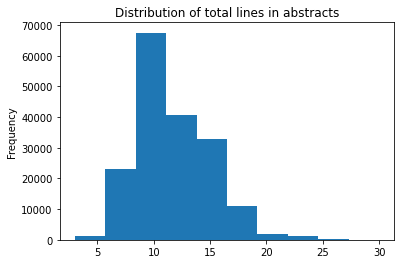

In [11]:
import matplotlib.pyplot as plt

# Check length of different lines
train_df.total_lines.plot.hist()
plt.title("Distribution of total lines in abstracts")

### Get lists of sentences

In [12]:
# Convert abstract text lines into lists
train_sentences = train_df.text.tolist()
val_sentences = val_df.text.tolist()
test_sentences = test_df.text.tolist()
len(train_sentences), len(val_sentences), len(test_sentences)

(180040, 30212, 30135)

In [13]:
# View the first 10 lines of the training data
train_sentences[:10]

['to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
 'secondary outcome measures included the western ontario and mcmaster universities osteoarthritis index scores , patient global assessment ( pga ) of the severity of knee oa , and @-min walk distance ( @mwd ) .',
 'serum levels of interleukin @ ( il-@ ) , il-@ , tumor necrosis factor ( tnf ) - , and high-sensitivity c-reactive protein ( hscrp ) were measured .',
 'there was a clinic

### Make numeric labels

In [14]:
import tensorflow as tf
# Onehot encoded labels
from sklearn.preprocessing import OneHotEncoder 
# alternatively use tf.one_hot
one_hot_encoder = OneHotEncoder(sparse=False) # We want a non-sparse matrix
train_labels_one_hot = one_hot_encoder.fit_transform(train_df.target.to_numpy().reshape(-1, 1))
val_labels_one_hot = one_hot_encoder.transform(val_df.target.to_numpy().reshape(-1, 1))
test_labels_one_hot = one_hot_encoder.transform(test_df.target.to_numpy().reshape(-1, 1))
# Check what one_hot encoded labels look like
train_labels_one_hot
tf.constant(train_labels_one_hot)

2022-09-14 11:41:54.174888: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


<tf.Tensor: shape=(180040, 5), dtype=float64, numpy=
array([[0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])>

In [15]:
import sklearn
print(sklearn.__version__)

1.1.2


### Label encode labels

In [16]:
# Extract labels ("target" columns) and encode them into integers
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_df.target.to_numpy())
val_labels_encoded = label_encoder.transform(val_df.target.to_numpy())
test_labels_encoded = label_encoder.transform(test_df.target.to_numpy())
# Check what encoded labels look like
train_labels_encoded[:12]


array([3, 2, 2, 2, 2, 2, 4, 4, 4, 4, 4, 1])

In [17]:
# Get class names and number of classes from LabelEncoder instance
num_classes = len(label_encoder.classes_)
class_names = label_encoder.classes_
num_classes, class_names

(5,
 array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
       dtype=object))

## Series of Experiments

* 0 - Naive Bayes with TF-IDF encoder (baseline)
* 1 - Conv1D with token embeddings
* 2 - TF Hub Pretrained Feature Extractor
* 3 - Conv1D with character embeddings
* 4 - Combining pretrained token embeddings + characters embeddings (hybrid embedding layer)
* 5 - Combining pretrained token embeddings + characters embeddings + positional embeddings

[Machine Learning Testing Map](https://scikit-learn.org/stable/tutorial/machine_learning_map/index.html)

## 0 Baseline Model: Naive Bayes

In [18]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

# Create tokenization and modelling pipeline
model_0 = Pipeline([
    ("tfidf", TfidfVectorizer()), # convert words to numbers using tfidf
    ("clf", MultinomialNB()), # model the text using a naive bayes classifier
])

# Fit the pipeline to the training data
model_0.fit(train_sentences, train_labels_encoded)

Pipeline(steps=[('tfidf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [19]:
# Evaluate our baseline model
baseline_score =  model_0.score(val_sentences, val_labels_encoded)
print(f'Baseline accuracy score: {baseline_score * 100:.2f}%')

Baseline accuracy score: 72.18%


In [20]:
# Make predictions using baseline model
baseline_preds = model_0.predict(val_sentences)
baseline_preds

array([4, 1, 3, ..., 4, 4, 1])

### Use helper functions script

In [21]:
from _helper_functions import calculate_results
# Calculate baseline results
baseline_results = calculate_results(y_true=val_labels_encoded,
                                        y_pred=baseline_preds)

baseline_results


{'accuracy': 72.1832384482987,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869,
 'f1': 0.6989250353450294}

26.338269273494777


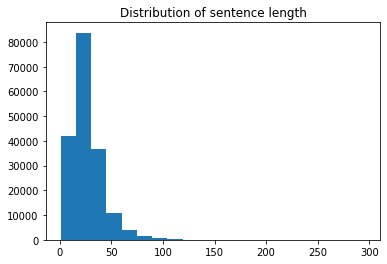

In [22]:
import matplotlib.pyplot as plt
import numpy as np

# Find the average number of tokens (words) in the training sentences
sent_lens = [len(sentence.split()) for sentence in train_sentences]
avg_sent_len = np.mean(sent_lens)
print(avg_sent_len)

# What's the distribution look like?
plt.hist(sent_lens, bins=20)
plt.title("Distribution of sentence length");

In [23]:
# How long of a sentence length covers 95% of the examples?
output_seq_len = int(np.percentile(sent_lens, 95))
print(output_seq_len, "tokens (words) or less covers 95% of training examples")

55 tokens (words) or less covers 95% of training examples


In [30]:
# Tokenize train sentences, turn it into an embedding and build a model
import numpy as np
import random
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
import random

# Setup text vectorization variables
max_vocab_len = 68000 # 68k value used in paper for PubMed 20k RCT, 200k is 331k

# Create text vectorizer
text_vectorizer = TextVectorization(max_tokens=max_vocab_len,
                                    output_sequence_length=output_seq_len)
                                    
# Adapt the text vectorizer to the training texts
text_vectorizer.adapt(train_sentences)

In [40]:
# Vectorize random sentence & view
target_sentence = random.choice(train_sentences)
vectorized_sentence = text_vectorizer([target_sentence])
print(f"Text:\n{target_sentence}")
print(f"\nLength of text: {len(target_sentence.split())}")
print(f"\nVectorized text: {vectorized_sentence}")

Text:
for routine use , ons with enema instead of traditional preparation for colonoscopy with peg can not be generally recommended .

Length of text: 21

Vectorized text: [[   11   633    87  8627     7 12688  4236     4   803  1406    11  1629
      7  3234   171    31    36  1153   730     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0]]


In [32]:
# Explore: How many words are in the vocabulary?
rct_20k_text_vocab = text_vectorizer.get_vocabulary()
print(f"Number of words in vocab: {len(rct_20k_text_vocab)}")
print(f"Most common words: {rct_20k_text_vocab[:5]}")
print(f"Least common words: {rct_20k_text_vocab[-5:]}")

Number of words in vocab: 64841
Most common words: ['', '[UNK]', 'the', 'and', 'of']
Least common words: ['aainduced', 'aaigroup', 'aachener', 'aachen', 'aaacp']


In [33]:
# Get the config of our text vectorizer
text_vectorizer.get_config()

{'name': 'text_vectorization_2',
 'trainable': True,
 'batch_input_shape': (None,),
 'dtype': 'string',
 'max_tokens': 68000,
 'standardize': 'lower_and_strip_punctuation',
 'split': 'whitespace',
 'ngrams': None,
 'output_mode': 'int',
 'output_sequence_length': 55,
 'pad_to_max_tokens': False,
 'sparse': False,
 'ragged': False,
 'vocabulary': None,
 'idf_weights': None}

In [43]:
from tensorflow.keras import layers
# Create an embedding layer
token_embed = layers.Embedding(input_dim=len(rct_20k_text_vocab), # length of vocab
                                output_dim=128, # size of embedding vectors
                                mask_zero=True, # whether or not the input value 0 is a special "padding" value which should be masked out
                                name="token_embedding")

In [45]:
# Show example embedding

print(f"Original text:\n {target_sentence}\
        \n\nVectorized version: {vectorized_sentence}")  
embedded_sentence = token_embed(vectorized_sentence)
print(f"\nEmbedded version: {embedded_sentence}")
print(f"\nEmbedded version shape: {embedded_sentence.shape}")

Original text:
 for routine use , ons with enema instead of traditional preparation for colonoscopy with peg can not be generally recommended .        

Vectorized version: [[   11   633    87  8627     7 12688  4236     4   803  1406    11  1629
      7  3234   171    31    36  1153   730     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0]]

Embedded version: [[[-2.2568703e-02 -4.4393148e-02 -2.9465668e-03 ... -2.3519194e-02
   -3.3806909e-02 -2.1203041e-02]
  [-2.3031607e-03 -3.9004795e-03  8.9123473e-03 ... -1.5198216e-03
    4.0409457e-02 -1.1797033e-02]
  [-2.9892052e-02 -3.5852589e-02  1.9468654e-02 ... -3.9160110e-02
   -7.9143047e-04  2.8103758e-02]
  ...
  [-4.6045531e-02  2.1658838e-05  2.7361598e-02 ... -3.8099527e-02
    3.4526791e-02  3.3373151e-02]
  [-4.6045531e-02  2.1658838e-05  2.7361598e-02 ... -3.8

In [55]:
# Create datasets with the tf.data API
# Turn the data into TensorFlow datasets
train_dataset = tf.data.Dataset.from_tensor_slices((train_sentences, train_labels_one_hot))
val_dataset = tf.data.Dataset.from_tensor_slices((val_sentences, val_labels_one_hot))
test_dataset = tf.data.Dataset.from_tensor_slices((test_sentences, test_labels_one_hot))

train_dataset

<TensorSliceDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(5,), dtype=tf.float64, name=None))>

In [56]:
# Take the TensorFlow datasets and turn them into prefetched batches
BATCH_SIZE = 32
train_dataset = train_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
val_dataset = val_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

train_dataset


<PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

In [59]:
# Create a 1D conv model with token embedding to process sequences

inputs = layers.Input(shape=(1,), dtype=tf.string)
text_vectors = text_vectorizer(inputs)
token_embeddings = token_embed(text_vectors)
x = layers.Conv1D(64, 5, activation="relu")(token_embeddings)
x = layers.GlobalAveragePooling1D()(x)
outputs = layers.Dense(num_classes, activation="softmax")(x)
model_1 = tf.keras.Model(inputs, outputs, name="model_1_conv1D")

# Get a summary of our model
model_1.summary()

Model: "model_1_conv1D"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_2 (TextV  (None, 55)               0         
 ectorization)                                                   
                                                                 
 token_embedding (Embedding)  (None, 55, 128)          8299648   
                                                                 
 conv1d_4 (Conv1D)           (None, 51, 64)            41024     
                                                                 
 global_average_pooling1d_4   (None, 64)               0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dense_4 (Dense)             (None, 5)              

In [60]:
from _helper_functions import create_tensorboard_callback
#Compile model
model_1.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [61]:
# Fit the model
history_1 = model_1.fit(train_dataset,
                        steps_per_epoch=int(0.1*len(train_dataset)),
                        epochs=3,
                        validation_data=val_dataset,
                        validation_steps=int(0.1*len(val_dataset)), # only validates on 10% of validation data
                        callbacks=[create_tensorboard_callback(dir_name="tensorflow_hub",
                                                                experiment_name="model_1_conv1D")])

Saving TensorBoard log files to: tensorflow_hub/model_1_conv1D/20220914
Epoch 1/3
562/562 [==============================] - 29s 51ms/step - loss: 0.9517 - accuracy: 0.6209 - val_loss: 0.7243 - val_accuracy: 0.7261
Epoch 2/3
562/562 [==============================] - 27s 47ms/step - loss: 0.6901 - accuracy: 0.7427 - val_loss: 0.6656 - val_accuracy: 0.7590
Epoch 3/3
562/562 [==============================] - 26s 46ms/step - loss: 0.6454 - accuracy: 0.7638 - val_loss: 0.6230 - val_accuracy: 0.7759


In [62]:
# Make predictions
model_1_pred_probs = model_1.predict(val_dataset)

945/945 [==============================] - 2s 2ms/step


In [63]:
model_1_pred_probs, model_1_pred_probs.shape

(array([[4.33648944e-01, 1.96612448e-01, 7.57519603e-02, 2.64770389e-01,
         2.92161107e-02],
        [4.89116788e-01, 1.99094385e-01, 1.26281846e-02, 2.91080475e-01,
         8.08016490e-03],
        [1.98368773e-01, 2.71563586e-02, 3.71783995e-03, 7.70604968e-01,
         1.52008986e-04],
        ...,
        [3.74743240e-06, 9.26175271e-04, 5.91134769e-04, 3.23135487e-06,
         9.98475730e-01],
        [6.07970282e-02, 3.80269825e-01, 1.60065830e-01, 9.51323286e-02,
         3.03734958e-01],
        [2.20162168e-01, 5.31385243e-01, 7.52954185e-02, 6.82504624e-02,
         1.04906775e-01]], dtype=float32),
 (30212, 5))

In [64]:
# Convert prediction probabilities to class labels
model_1_preds = tf.argmax(model_1_pred_probs, axis=1)
model_1_preds[:10]

<tf.Tensor: shape=(10,), dtype=int64, numpy=array([0, 0, 3, 2, 4, 2, 4, 2, 4, 1])>

In [65]:
# Calculate model results
model_1_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_1_preds)
model_1_results

{'accuracy': 77.80021183635641,
 'precision': 0.7736911544544379,
 'recall': 0.7780021183635641,
 'f1': 0.7749848659001156}

In [66]:
baseline_results

{'accuracy': 72.1832384482987,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869,
 'f1': 0.6989250353450294}